# Vegetation phenology statistics Calculation on East Trinity Site A

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import display_map, rgb
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yshen@earthwatch.org.au/proxy/8787/status,
Dashboard: /user/yshen@earthwatch.org.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43483,Workers: 1
Dashboard: /user/yshen@earthwatch.org.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:36115,Total threads: 2
Dashboard: /user/yshen@earthwatch.org.au/proxy/43371/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:46501,


## Check the work dictionary

In [2]:
import os
print(os.getcwd())

/home/jovyan/NDVI


In [3]:
#change the current working directory
os.chdir('/home/jovyan/NDVI')

## Import and read 'East site A' shapefile

In [4]:
#read shapefile 
import geopandas as gpd
eastsiteA = gpd.read_file('/home/jovyan/NDVI/shapeFile/East_Trinity_SiteA.shp')

In [5]:
# Change the coordinate system
wgs84_epsg = 4326
eastsiteA_gdf = eastsiteA.to_crs(wgs84_epsg)

In [6]:
# Get the bounding box (lat_min, lat_max, lon_min, lon_max) of the area
bounding_box_df = eastsiteA_gdf.bounds

# Extract the values from the DataFrame.
eastsiteA_lat_min = bounding_box_df['miny'].min()
eastsiteA_lat_max = bounding_box_df['maxy'].max()
eastsiteA_lon_min = bounding_box_df['minx'].min()
eastsiteA_lon_max = bounding_box_df['maxx'].max()

# Print the bounding box coordinates.
print("Latitude Min:", eastsiteA_lat_min)
print("Latitude Max:", eastsiteA_lat_max)
print("Longitude Min:", eastsiteA_lon_min)
print("Longitude Max:", eastsiteA_lon_max)


Latitude Min: -16.93184192399997
Latitude Max: -16.930055006999986
Longitude Min: 145.78691016599998
Longitude Max: 145.7881183759598


## Plot 'East site A' shapefile on basemap 

/env/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


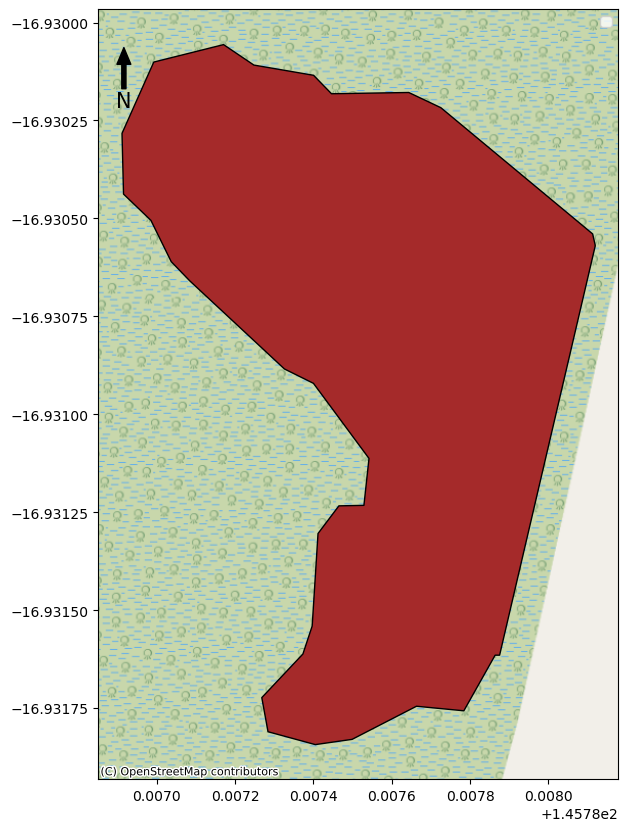

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=10)

# Assuming 'East' is the GeoDataFrame with your data.
# If not, replace 'East' with your actual GeoDataFrame.
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the layers
eastsiteA_gdf.plot(ax=ax, color='brown', edgecolor='black', legend=True)

# Add a north arrow
x, y, arrow_length = 0.05, 0.95, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# Add OpenStreetMap basemap
cx.add_basemap(ax, crs=eastsiteA_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend()

plt.show()


## Define area of interest with East Site A

In [9]:
# Define area of interest
lat_min, lat_max = eastsiteA_lat_min, eastsiteA_lat_max
lon_min, lon_max = eastsiteA_lon_min, eastsiteA_lon_max

# Set the range of dates for the analysis
time_range = ('2016-04-19', '2023-05-13')

# Set the vegetation proxy to use
veg_proxy = 'NDVI'


In [10]:
dc = datacube.Datacube(app='Vegetation_phenology')

## Review the location on display_map

In [11]:
display_map(x=(lon_min, lon_max), y=(lat_min, lat_max))

## Load dataset of selected location from Sentinel-2

In [12]:
# Create a reusable query
query = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    cloud_mask='s2cloudless',
    min_gooddata=0.9,
    **query,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 333 out of 924 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 333 time steps


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 333, y: 12, x: 7)
Coordinates:
  * time         (time) datetime64[ns] 2016-04-19T00:30:34.457000 ... 2023-03...
  * y            (y) float64 -2.129e+06 -2.129e+06 ... -2.13e+06 -2.13e+06
  * x            (x) float64 1.407e+07 1.407e+07 ... 1.407e+07 1.407e+07
    spatial_ref  int32 6933
Data variables:
    nbart_red    (time, y, x) float32 291.0 300.0 365.0 ... 758.0 344.0 322.0
    nbart_green  (time, y, x) float32 446.0 448.0 535.0 ... 800.0 446.0 472.0
    nbart_blue   (time, y, x) float32 296.0 259.0 356.0 ... 560.0 330.0 318.0
    nbart_nir_1  (time, y, x) float32 1.781e+03 1.872e+03 ... 2.882e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Clip the dataset using the boundary of East site A

In [13]:
import geopandas as gpd
import rioxarray as rxr

# Ensure that the GeoDataFrame and dataset have the same CRS
eastsiteA_gdf = eastsiteA_gdf.to_crs(ds.crs)

# Clip the dataset using the boundary of eastsiteA_gdf
ds_clipped = ds.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_clipped


<xarray.Dataset>
Dimensions:      (time: 333, y: 11, x: 6)
Coordinates:
  * time         (time) datetime64[ns] 2016-04-19T00:30:34.457000 ... 2023-03...
  * y            (y) float64 -2.129e+06 -2.129e+06 ... -2.13e+06 -2.13e+06
  * x            (x) float64 1.407e+07 1.407e+07 ... 1.407e+07 1.407e+07
    spatial_ref  int64 0
Data variables:
    nbart_red    (time, y, x) float32 305.0 399.0 -999.0 ... -999.0 -999.0
    nbart_green  (time, y, x) float32 452.0 549.0 -999.0 ... -999.0 -999.0
    nbart_blue   (time, y, x) float32 295.0 387.0 -999.0 ... -999.0 -999.0
    nbart_nir_1  (time, y, x) float32 1.893e+03 1.715e+03 ... -999.0 -999.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Review the clipped dataset

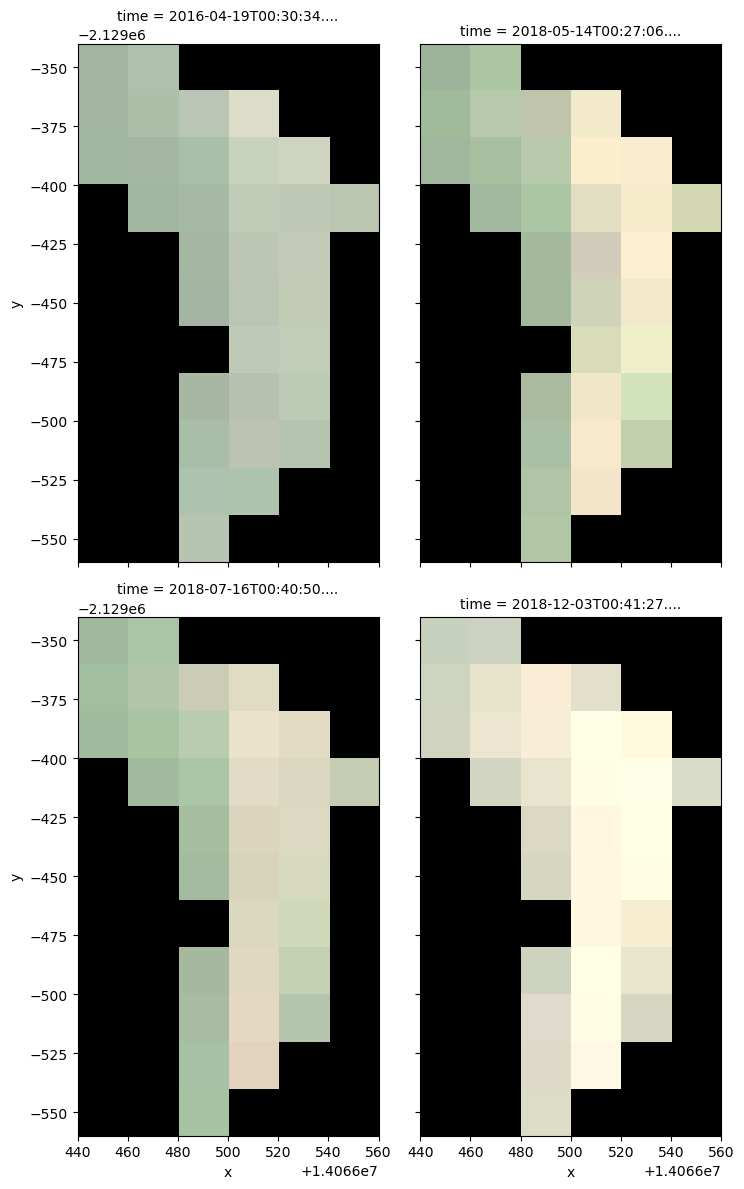

In [14]:
rgb(ds_clipped, index=[0, 80, 90, 121], col_wrap=2)

## NDVI Statistic Calculation using Sentinel-2 between 2016 and 2023

In [15]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_clipped = calculate_indices(ds_clipped, index=veg_proxy, collection='ga_s2_3')

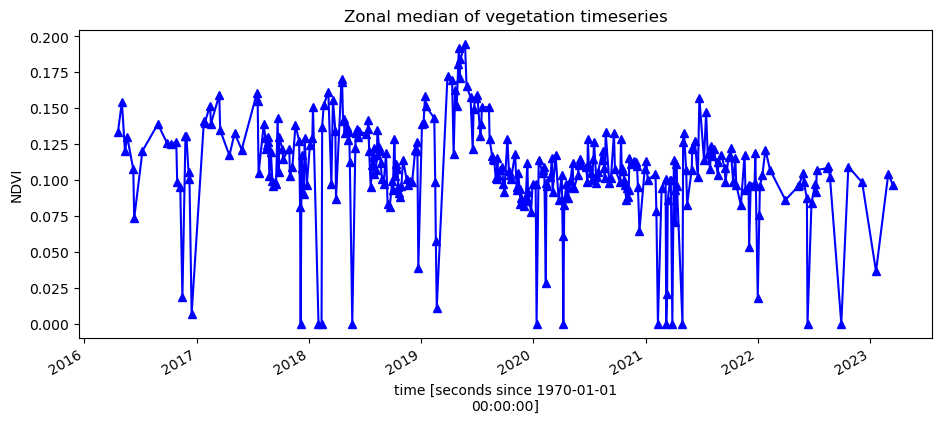

In [16]:
# Plot the zonal median of vegetation timeseries
ds_clipped.NDVI.median(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal median of vegetation timeseries');

## Resample the timeseries dataset into unit of one month

In [17]:
resample_period='1M'
window=4

veg_smooth=ds_clipped[veg_proxy].resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

Text(0, 0.5, 'NDVI')

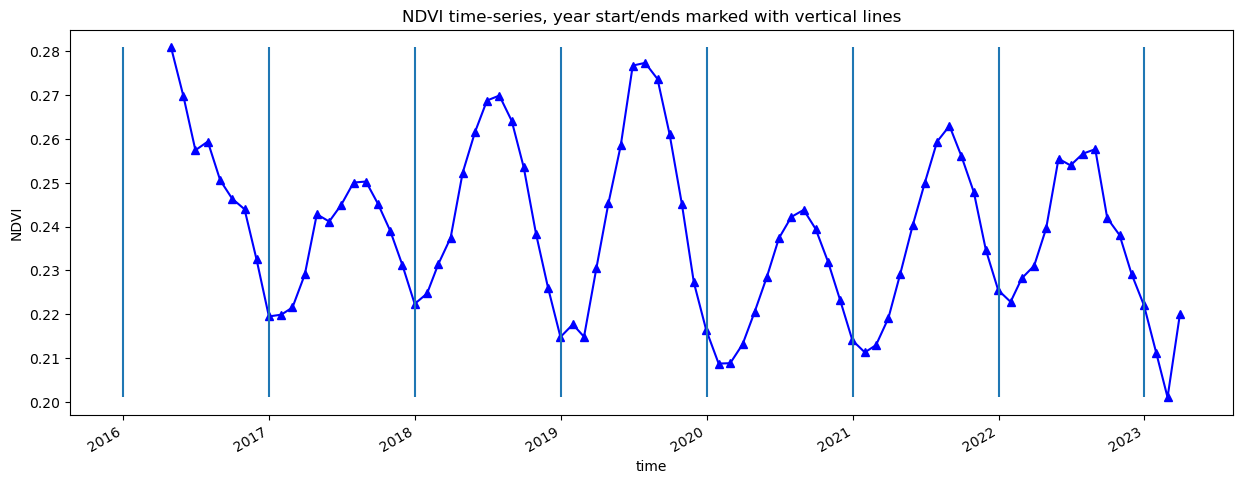

In [18]:
veg_smooth_1D = veg_smooth.mean(['x', 'y'])
veg_smooth_1D.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D.max()
_min=veg_smooth_1D.min()


for year in range(2016, 2024):
    plt.vlines(np.datetime64(str(year)+'-01-01'), ymin=_min, ymax=_max)

plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
plt.ylabel(veg_proxy)

## Save zonal median vegetation timeseries data (Sentinel-2) (2016-2023) to a CSV file
## Plot 'Zonal median of vegetation timeseries with annual trend line'

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yshen@earthwatch.org.au/proxy/8787/status,
Dashboard: /user/yshen@earthwatch.org.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34603,Workers: 1
Dashboard: /user/yshen@earthwatch.org.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:35565,Total threads: 2
Dashboard: /user/yshen@earthwatch.org.au/proxy/38157/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:35397,


Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 333 out of 914 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 333 time steps


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


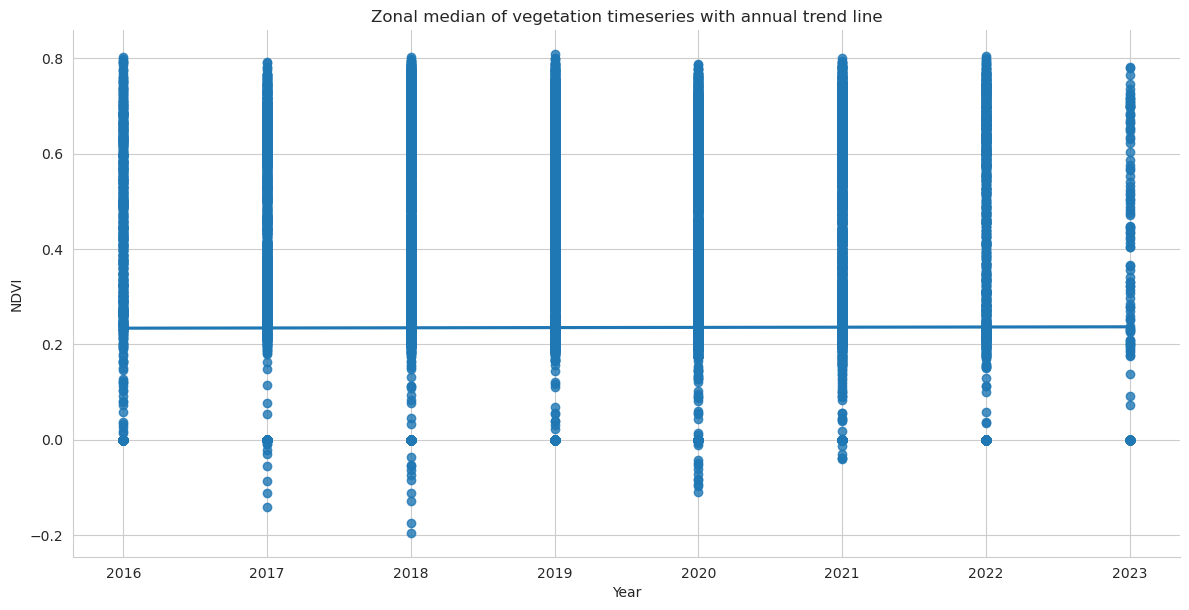

In [19]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import display_map, rgb
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)
dc = datacube.Datacube(app='Vegetation_phenology')
# Define area of interest
lat_min, lat_max = eastsiteA_lat_min, eastsiteA_lat_max
lon_min, lon_max = eastsiteA_lon_min, eastsiteA_lon_max

# Set the range of dates for the analysis
time_range = ('2016-04-19', '2023-04-19')

# Set the vegetation proxy to use
veg_proxy = 'NDVI'
display_map(x=(lon_min, lon_max), y=(lat_min, lat_max))
# Create a reusable query
query = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    cloud_mask='s2cloudless',
    min_gooddata=0.9,
    **query,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds

import geopandas as gpd
import rioxarray as rxr

# Ensure that the GeoDataFrame and dataset have the same CRS
eastsiteA_gdf = eastsiteA_gdf.to_crs(ds.crs)

# Clip the dataset using the boundary of eastsiteA_gdf
ds_clipped = ds.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_clipped


# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_clipped = calculate_indices(ds_clipped, index=veg_proxy, collection='ga_s2_3')

# Convert the xarray dataset to a pandas dataframe
df = ds_clipped[veg_proxy].to_dataframe().reset_index()

# Add a year column to the dataframe
df['year'] = pd.DatetimeIndex(df['time']).year

# Plot the annual trend line with seaborn
sns.set_style('whitegrid')
sns.lmplot(x='year', y=veg_proxy, data=df, height=6, aspect=2, ci=None)

# Add a title and labels to the plot
plt.title('Zonal median of vegetation timeseries with annual trend line')
plt.xlabel('Year')
plt.ylabel('NDVI')

# Save the plot as a .jpg file
plt.savefig('veg_timeseries.jpg')

# Save zonal median vegetation timeseries data to a CSV file
df = ds_clipped.NDVI.median(['x', 'y']).to_dataframe(name='NDVI')
df.to_csv('zonal_median_vegetation_timeseries.csv')


## NDVI Statistic Calculation using Sentinel-2 between 1992 and 2023

In [21]:
time_range = ('1992-04-19', '2023-05-13')

# Create a reusable query
query = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds_s2_1992 = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    cloud_mask='s2cloudless',
    min_gooddata=0.9,
    **query,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds_s2_1992

# Ensure that the GeoDataFrame and dataset have the same CRS
eastsiteA_gdf = eastsiteA_gdf.to_crs(ds_s2_1992.crs)

# Clip the dataset using the boundary of eastsiteA_gdf
ds_s2_1992_clipped = ds_s2_1992.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_s2_1992_clipped

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 344 out of 950 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 344 time steps


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 344, y: 11, x: 6)
Coordinates:
  * time         (time) datetime64[ns] 2015-09-12T00:31:38.457000 ... 2023-03...
  * y            (y) float64 -2.129e+06 -2.129e+06 ... -2.13e+06 -2.13e+06
  * x            (x) float64 1.407e+07 1.407e+07 ... 1.407e+07 1.407e+07
    spatial_ref  int64 0
Data variables:
    nbart_red    (time, y, x) float32 1.226e+03 1.26e+03 ... -999.0 -999.0
    nbart_green  (time, y, x) float32 1.455e+03 1.42e+03 ... -999.0 -999.0
    nbart_blue   (time, y, x) float32 1.372e+03 1.314e+03 ... -999.0 -999.0
    nbart_nir_1  (time, y, x) float32 2.499e+03 2.463e+03 ... -999.0 -999.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [22]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_s2_1992_clipped = calculate_indices(ds_s2_1992_clipped, index=veg_proxy, collection='ga_s2_3')

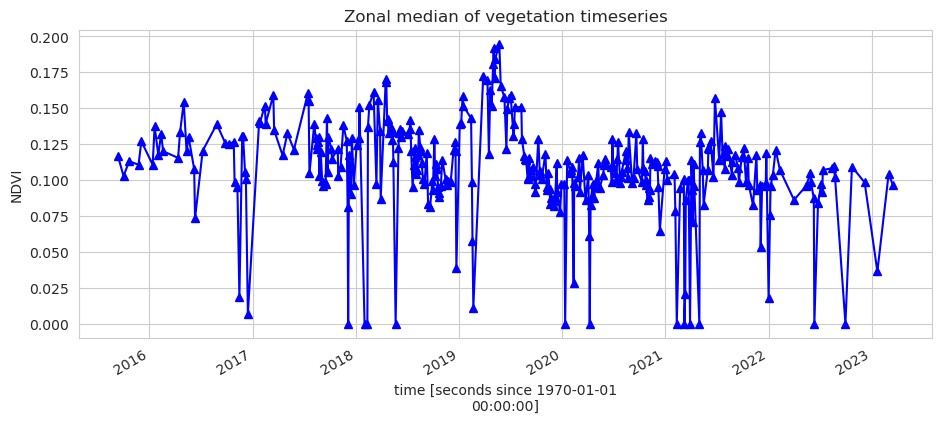

In [23]:
ds_s2_1992_clipped.NDVI.median(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal median of vegetation timeseries');

## Resample the timeseries dataset into unit of one month

In [24]:
resample_period='1M'
window=4

veg_smooth_s2_1992=ds_s2_1992_clipped[veg_proxy].resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()


Text(0, 0.5, 'NDVI')

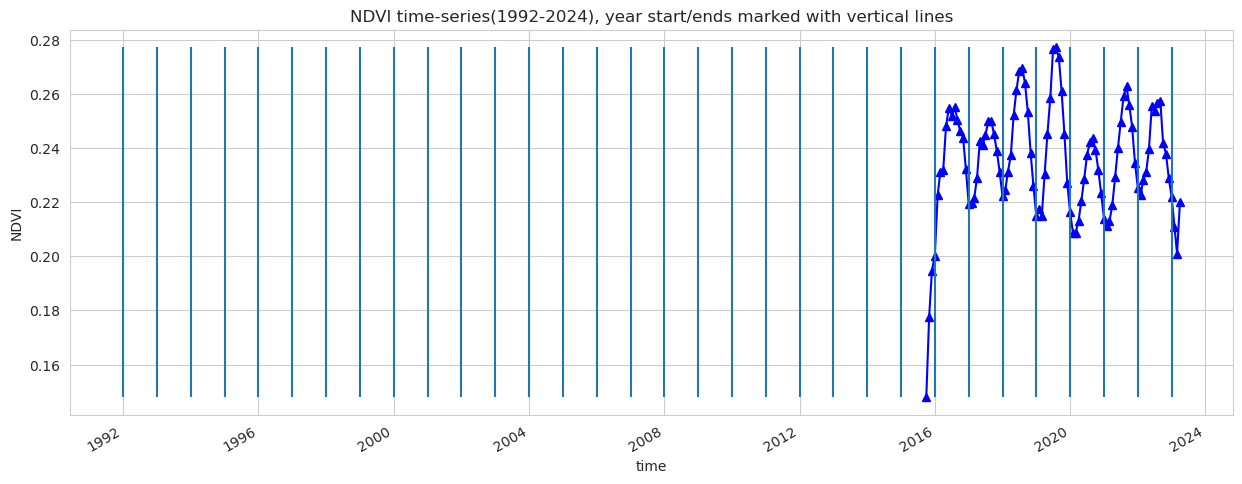

In [25]:
veg_smooth_1D_s2_1992 = veg_smooth_s2_1992.mean(['x', 'y'])
veg_smooth_1D_s2_1992.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D_s2_1992.max()
_min=veg_smooth_1D_s2_1992.min()

for year in range(1992, 2024):
    plt.vlines(np.datetime64(str(year)+'-01-01'), ymin=_min, ymax=_max)

plt.title(veg_proxy+' time-series(1992-2024), year start/ends marked with vertical lines')
plt.ylabel(veg_proxy)

In [26]:
# Save zonal median vegetation timeseries data to a CSV file
df = ds_clipped.NDVI.median(['x', 'y']).to_dataframe(name='NDVI')
df.to_csv('zonal_median_vegetation_timeseries(1992, 2023).csv')

## NDVI Statistic Calculation using Landsat imagery (5,7 & 8) between 2016 and 2023

In [32]:
# Create a Zonal Median NDVI Plot of East Trinity Site A polygon with csv data export using Landsat imagery (5,7 & 8) from 2016 – today. 

# Set the range of dates for the analysis
time_range_2016 = ('2016-04-19', '2023-05-13')

query_2016 = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range_2016,
    'measurements': ['red', 'nir'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by': 'solar_day'
}

# Load available data from Landsat (Landsat 5, 7, and 8)
ds_2016 = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    min_gooddata=0.9,
    **query_2016,
)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 191 out of 541 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 191 time steps


## Clip the dataset using the boundary of East site A

In [33]:
import geopandas as gpd
import rioxarray as rxr

# Clip the dataset using the boundary of eastsiteA_gdf
ds_2016_clipped = ds_2016.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_2016_clipped

<xarray.Dataset>
Dimensions:      (time: 191, y: 11, x: 6)
Coordinates:
  * time         (time) datetime64[ns] 2016-04-30T00:16:00.034071 ... 2023-04...
  * y            (y) float64 -2.129e+06 -2.129e+06 ... -2.13e+06 -2.13e+06
  * x            (x) float64 1.407e+07 1.407e+07 ... 1.407e+07 1.407e+07
    spatial_ref  int64 0
Data variables:
    red          (time, y, x) float32 213.0 256.0 -999.0 ... -999.0 -999.0
    nir          (time, y, x) float32 831.0 797.0 -999.0 ... -999.0 -999.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

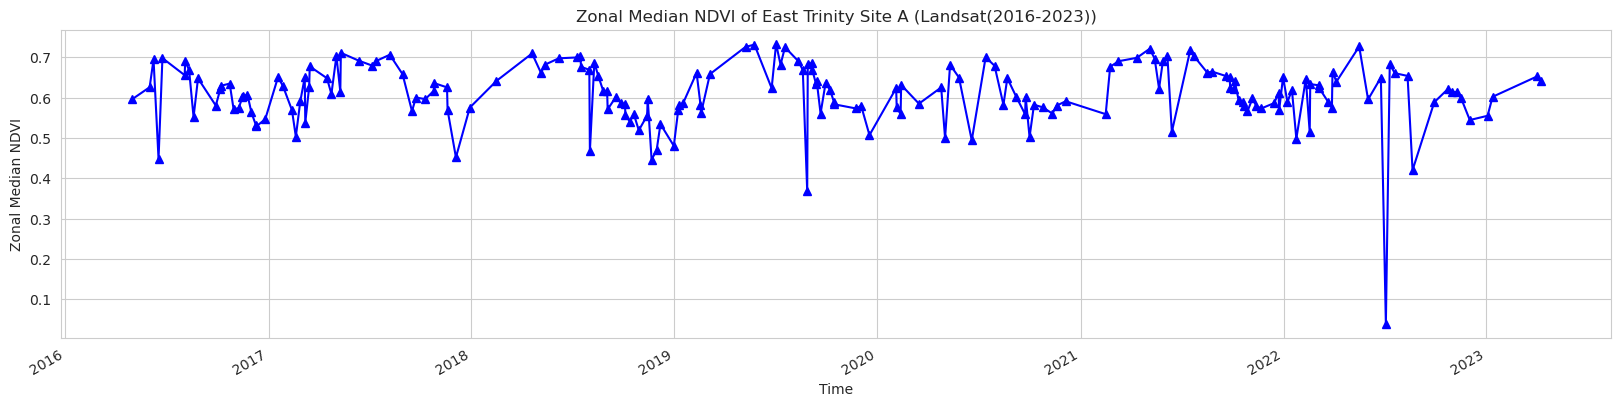

In [34]:
# Shut down Dask client now that we have loaded the data we need
client.close()

# Function to calculate NDVI
def calculate_ndvi(ds_2016):
    ndvi_2016 = (ds_2016['nir'] - ds_2016['red']) / (ds_2016['nir'] + ds_2016['red'])
    return ndvi_2016

# Calculate NDVI
ndvi_2016 = calculate_ndvi(ds_2016)

# Compute zonal median of NDVI for each time step
zonal_median_ndvi = ndvi_2016.median(dim=['x', 'y'])

# Create a time series plot of zonal median NDVI
plt.figure(figsize=(20, 4))
zonal_median_ndvi.plot.line('b-^')
plt.title('Zonal Median NDVI of East Trinity Site A (Landsat(2016-2023))')
plt.xlabel('Time')
plt.ylabel('Zonal Median NDVI')
plt.grid(True)
plt.show()


## Resample the timeseries dataset into unit of one month

In [35]:
resample_period='1M'
window=4

veg_smooth_2016=ndvi_2016.resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

Text(0, 0.5, 'NDVI')

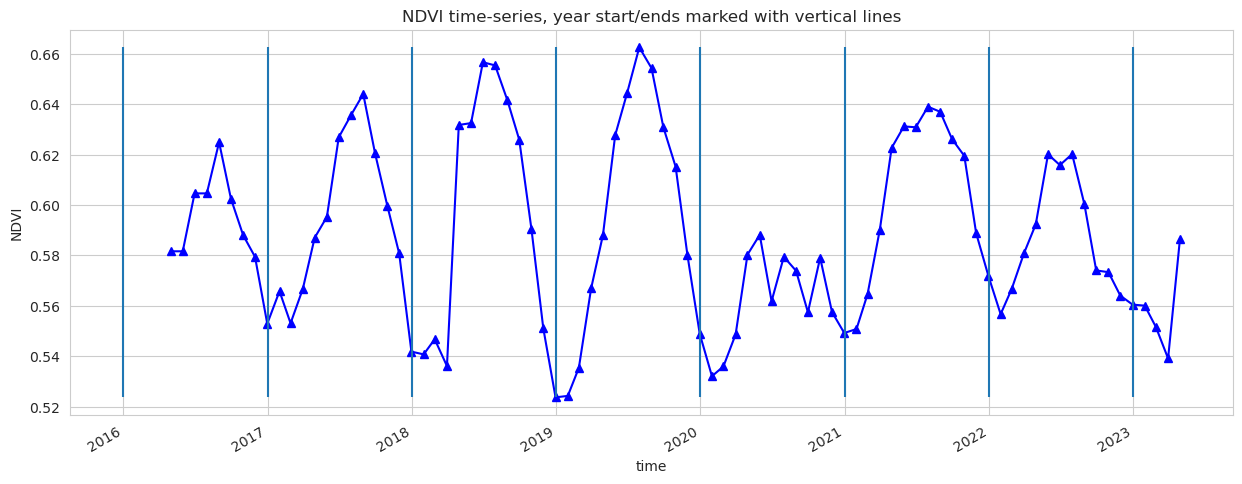

In [36]:
veg_smooth_1D_2016 = veg_smooth_2016.mean(['x', 'y'])
veg_smooth_1D_2016.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D_2016.max()
_min=veg_smooth_1D_2016.min()

for year in range(2016, 2024):
    plt.vlines(np.datetime64(str(year)+'-01-01'), ymin=_min, ymax=_max)

plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
plt.ylabel(veg_proxy)

## Save zonal median vegetation timeseries data (Landsat) (2016-2023) to a CSV file
## Plot 'Zonal median of vegetation timeseries with annual trend line'

In [38]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import display_map, rgb
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)
dc = datacube.Datacube(app='Vegetation_phenology')
# Define area of interest
lat_min, lat_max = eastsiteA_lat_min, eastsiteA_lat_max
lon_min, lon_max = eastsiteA_lon_min, eastsiteA_lon_max

# Set the range of dates for the analysis
time_range_2016 = ('2016-04-19', '2023-05-13')

# Set the vegetation proxy to use
veg_proxy = 'NDVI'
display_map(x=(lon_min, lon_max), y=(lat_min, lat_max))

# Create a reusable query
query_2016 = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range_2016,
    'measurements': ['red', 'nir'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by': 'solar_day'
}

# Load available data from Landsat (Landsat 5, 7, and 8)
ds_2016 = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    min_gooddata=0.9,
    **query_2016,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds_2016


# Clip the dataset using the boundary of eastsiteA_gdf
ds_2016_clipped = ds_2016.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_2016_clipped

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yshen@earthwatch.org.au/proxy/41041/status,
Dashboard: /user/yshen@earthwatch.org.au/proxy/41041/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46251,Workers: 1
Dashboard: /user/yshen@earthwatch.org.au/proxy/41041/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:36919,Total threads: 2
Dashboard: /user/yshen@earthwatch.org.au/proxy/40115/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:34653,


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 191 out of 541 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 191 time steps


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 191, y: 11, x: 6)
Coordinates:
  * time         (time) datetime64[ns] 2016-04-30T00:16:00.034071 ... 2023-04...
  * y            (y) float64 -2.129e+06 -2.129e+06 ... -2.13e+06 -2.13e+06
  * x            (x) float64 1.407e+07 1.407e+07 ... 1.407e+07 1.407e+07
    spatial_ref  int64 0
Data variables:
    red          (time, y, x) float32 213.0 256.0 -999.0 ... -999.0 -999.0
    nir          (time, y, x) float32 831.0 797.0 -999.0 ... -999.0 -999.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

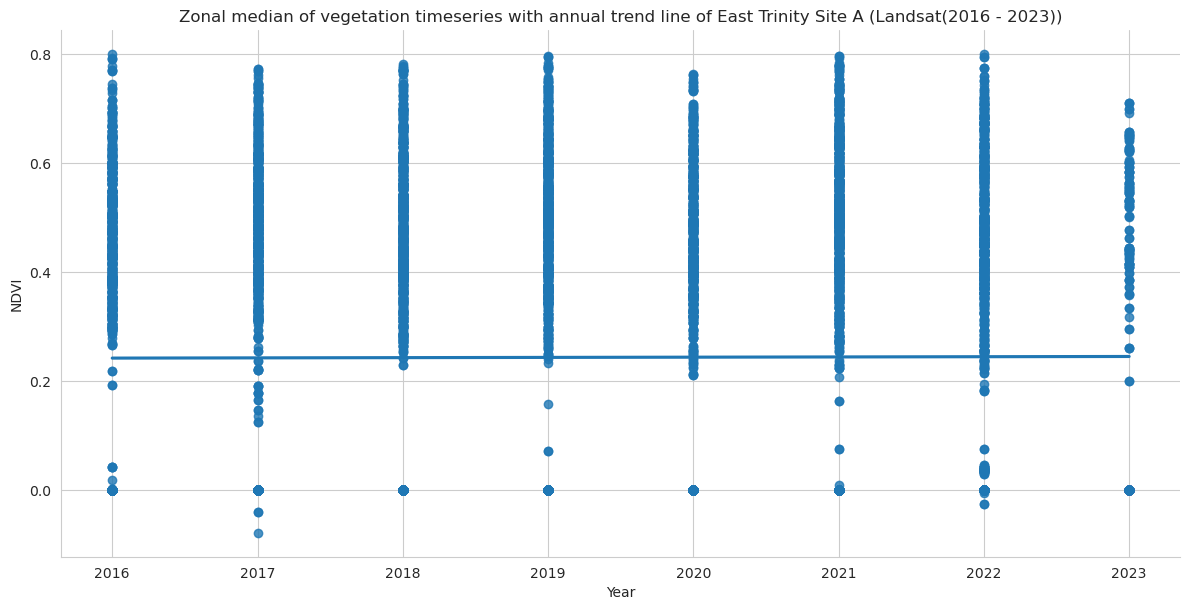

In [39]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_2016_clipped = calculate_indices(ds_2016_clipped, index=veg_proxy, collection='ga_ls_3')

# Convert the xarray dataset to a pandas dataframe
df_2016 = ds_2016_clipped[veg_proxy].to_dataframe().reset_index()

# Add a year column to the dataframe
df_2016['year'] = pd.DatetimeIndex(df_2016['time']).year

# Plot the annual trend line with seaborn
sns.set_style('whitegrid')
sns.lmplot(x='year', y=veg_proxy, data=df_2016, height=6, aspect=2, ci=None)

# Add a title and labels to the plot
plt.title('Zonal median of vegetation timeseries with annual trend line of East Trinity Site A (Landsat(2016 - 2023))')
plt.xlabel('Year')
plt.ylabel('NDVI')

# Save the plot as a .jpg file
plt.savefig('veg_timeseries(Landsat(2016 - 2023)).jpg')

# Save zonal median vegetation timeseries data to a CSV file
df_2016 = ds_2016_clipped.NDVI.median(['x', 'y']).to_dataframe(name='NDVI')
df_2016.to_csv('zonal_median_vegetation_timeseries(Landsat(2016 - 2023)).csv')


## NDVI Statistic Calculation using Landsat imagery (5,7 & 8) between 1992 and 2023

In [40]:
# Create a Zonal Median NDVI Plot of East Trinity Site A polygon with csv data export using Landsat imagery (5,7 & 8) from 1992 – today. 

# Set the range of dates for the analysis
time_range_1992 = ('1992-04-19', '2023-05-13')

query_1992 = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range_1992,
    'measurements': ['red', 'nir'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by': 'solar_day'
}

# Load available data from Landsat (Landsat 5, 7, and 8)
ds_1992 = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    min_gooddata=0.9,
    **query_1992,
)

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 637 out of 1710 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 637 time steps


## Clip the dataset using the boundary of East site A

In [41]:
import geopandas as gpd
import rioxarray as rxr

# Clip the dataset using the boundary of eastsiteA_gdf
ds_1992_clipped = ds_1992.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_1992_clipped


<xarray.Dataset>
Dimensions:      (time: 637, y: 11, x: 6)
Coordinates:
  * time         (time) datetime64[ns] 1992-05-13T23:40:06.823223 ... 2023-04...
  * y            (y) float64 -2.129e+06 -2.129e+06 ... -2.13e+06 -2.13e+06
  * x            (x) float64 1.407e+07 1.407e+07 ... 1.407e+07 1.407e+07
    spatial_ref  int64 0
Data variables:
    red          (time, y, x) float32 740.0 777.0 -999.0 ... -999.0 -999.0
    nir          (time, y, x) float32 2.048e+03 1.607e+03 ... -999.0 -999.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

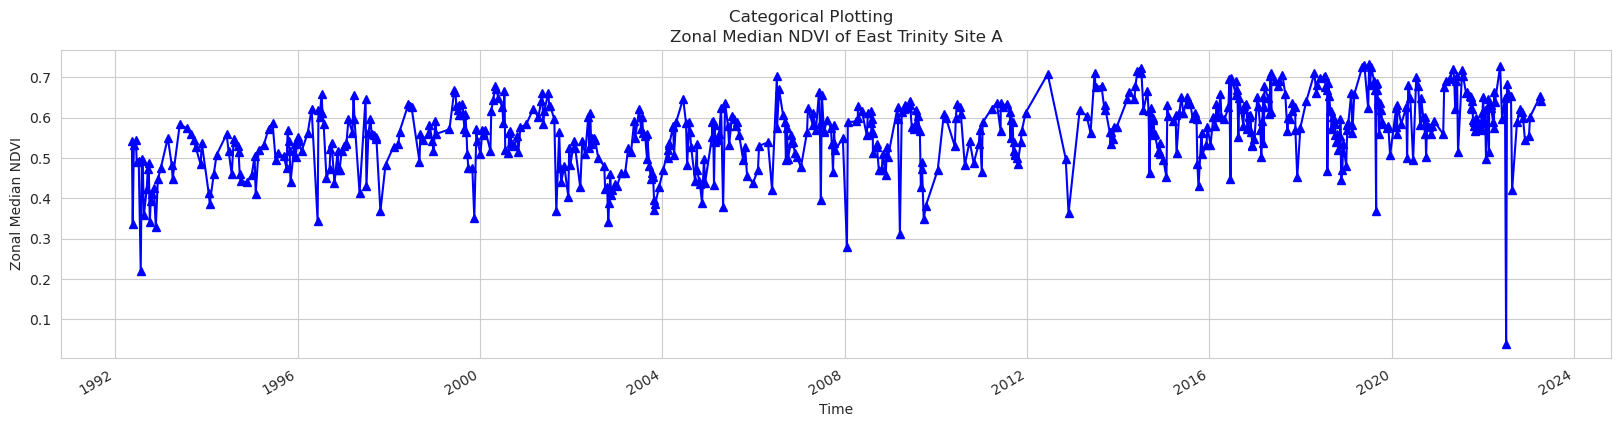

In [54]:
# Shut down Dask client now that we have loaded the data we need
client.close()

# Function to calculate NDVI
def calculate_ndvi(ds_1992):
    ndvi_1992 = (ds_1992['nir'] - ds_1992['red']) / (ds_1992['nir'] + ds_1992['red'])
    return ndvi_1992

# Calculate NDVI
ndvi_1992 = calculate_ndvi(ds_1992)

# Compute zonal median of NDVI for each time step
zonal_median_ndvi = ndvi_1992.median(dim=['x', 'y'])

# Create a time series plot of zonal median NDVI
plt.figure(figsize=(20, 4))
zonal_median_ndvi.plot.line('b-^')
plt.suptitle('Categorical Plotting')
plt.title('Zonal Median NDVI of East Trinity Site A')
plt.xlabel('Time')
plt.ylabel('Zonal Median NDVI')
plt.grid(True)
plt.show()


## Resample the timeseries dataset into unit of one month

In [43]:
resample_period='1M'
window=4

veg_smooth_1992=ndvi_1992.resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()

Text(0, 0.5, 'NDVI')

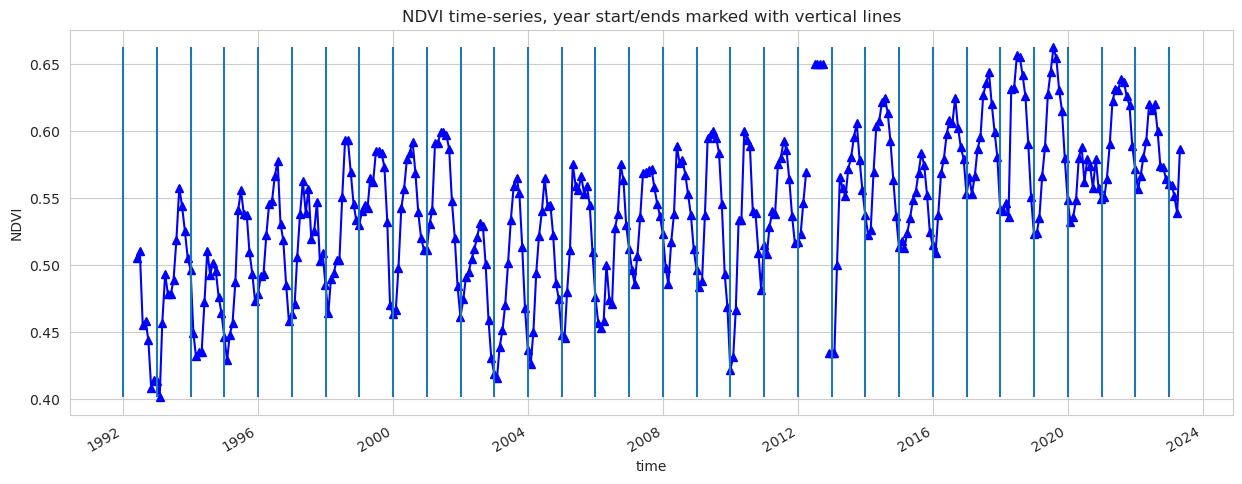

In [83]:
veg_smooth_1D_1992 = veg_smooth_1992.mean(['x', 'y'])
veg_smooth_1D_1992.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D_1992.max()
_min=veg_smooth_1D_1992.min()

for year in range(1992, 2024):
    plt.vlines(np.datetime64(str(year)+'-01-01'), ymin=_min, ymax=_max)

plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
plt.ylabel(veg_proxy)

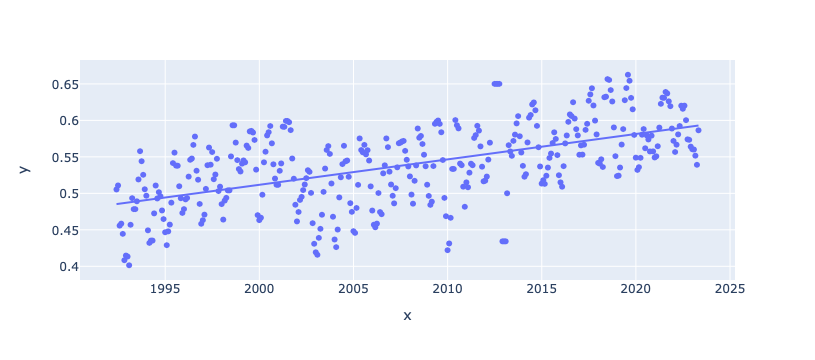

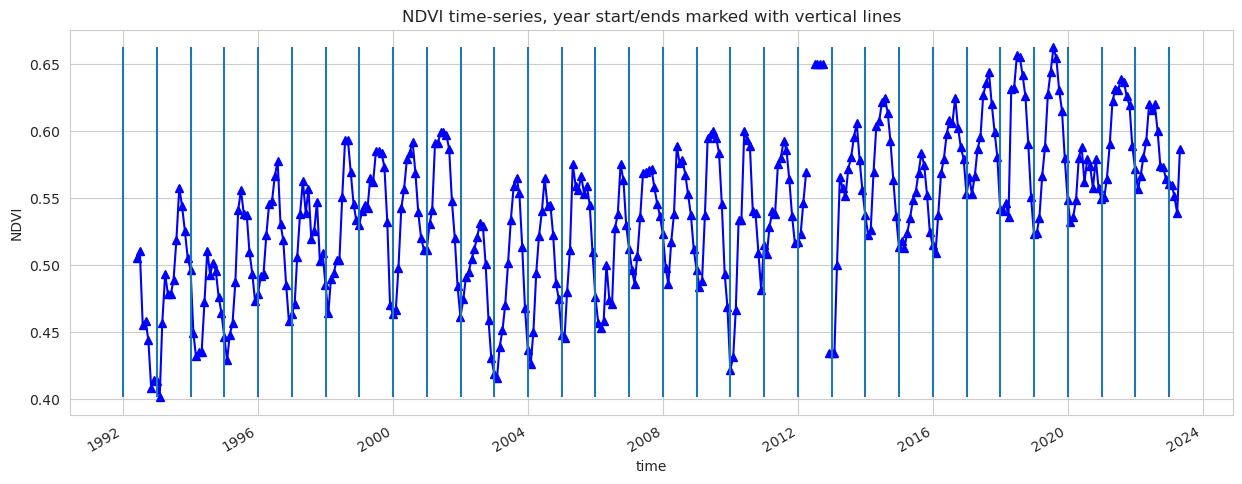

In [91]:
import numpy as np
import matplotlib.pyplot as plt

veg_smooth_1D_1992 = veg_smooth_1992.mean(['x', 'y'])
veg_smooth_1D_1992.plot.line('b-^', figsize=(15,5))
_max = veg_smooth_1D_1992.max().item()  # Extracting scalar value
_min = veg_smooth_1D_1992.min().item()  # Extracting scalar value

for year in range(1992, 2024):
    plt.vlines(np.datetime64(str(year)+'-01-01'), ymin=_min, ymax=_max)

# scatter plot using dates as x and veg_smooth_1D_1992 as y
x_datetime = veg_smooth_1D_1992.coords['time'].values.astype('datetime64[D]')
y = veg_smooth_1D_1992.values  # using .values to extract data from DataArray

import plotly.express as px

fig = px.scatter(x=x_datetime, y=y, trendline="ols")
fig.show()

plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
plt.ylabel(veg_proxy)

plt.show()  # Show the plot


## Save zonal median vegetation timeseries data (landsat) (1992-2023) to a CSV file
## Plot 'Zonal median of vegetation timeseries with annual trend line'

In [ ]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import display_map, rgb
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)
dc = datacube.Datacube(app='Vegetation_phenology')
# Define area of interest
lat_min, lat_max = eastsiteA_lat_min, eastsiteA_lat_max
lon_min, lon_max = eastsiteA_lon_min, eastsiteA_lon_max

# Set the range of dates for the analysis
time_range_1992 = ('1992-04-19', '2023-05-13')

# Set the vegetation proxy to use
veg_proxy = 'NDVI'
display_map(x=(lon_min, lon_max), y=(lat_min, lat_max))

# Create a reusable query
query_1992 = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range_1992,
    'measurements': ['red', 'nir'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by': 'solar_day'
}

# Load available data from Landsat (Landsat 5, 7, and 8)
ds_1992 = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    min_gooddata=0.9,
    **query_1992,
)

# Shut down Dask client now that we have loaded the data we need
client.close()

# Preview data
ds_1992


# Clip the dataset using the boundary of eastsiteA_gdf
ds_1992_clipped = ds_1992.rio.clip(eastsiteA_gdf.geometry)

# Preview the clipped dataset
ds_1992_clipped

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yshen@earthwatch.org.au/proxy/32807/status,
Dashboard: /user/yshen@earthwatch.org.au/proxy/32807/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42903,Workers: 1
Dashboard: /user/yshen@earthwatch.org.au/proxy/32807/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:43983,Total threads: 2
Dashboard: /user/yshen@earthwatch.org.au/proxy/40609/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:46499,


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask


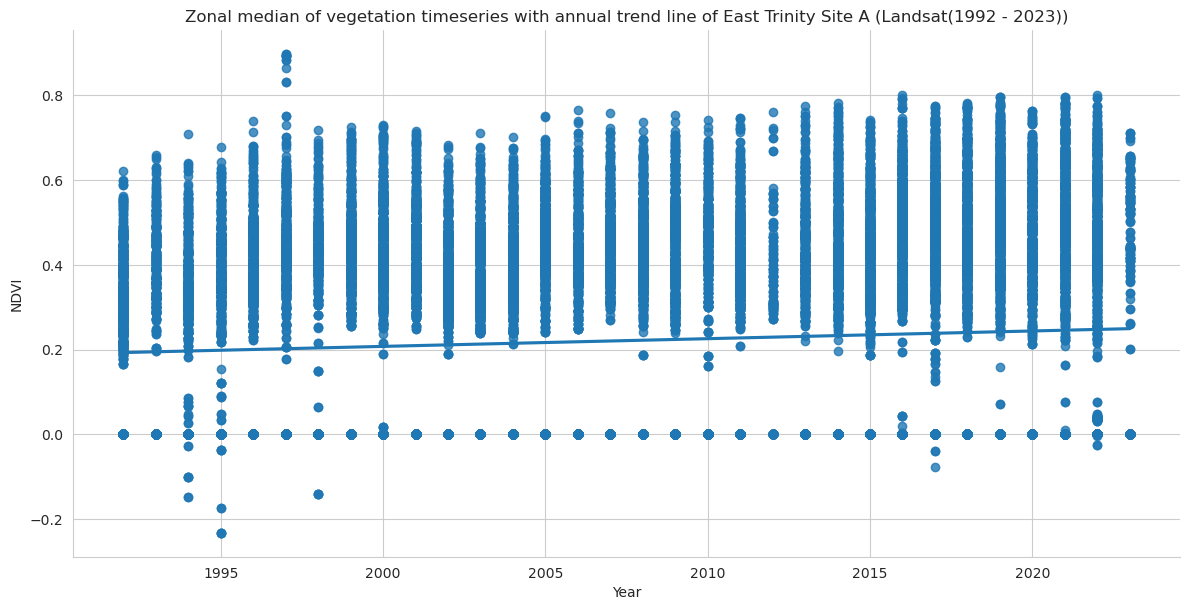

In [100]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_1992_clipped = calculate_indices(ds_1992_clipped, index=veg_proxy, collection='ga_ls_3')

# Convert the xarray dataset to a pandas dataframe
df_1992 = ds_1992_clipped[veg_proxy].to_dataframe().reset_index()

# Add a year column to the dataframe
df_1992['year'] = pd.DatetimeIndex(df_1992['time']).year

# Plot the annual trend line with seaborn
sns.set_style('whitegrid')
sns.lmplot(x='year', y=veg_proxy, data=df_1992, height=6, aspect=2, ci=None)

# Add a title and labels to the plot
plt.title('Zonal median of vegetation timeseries with annual trend line of East Trinity Site A (Landsat(1992 - 2023))')
plt.xlabel('Year')
plt.ylabel('NDVI')

# Save the plot as a .jpg file
plt.savefig('veg_timeseries(Landsat(1992 - 2023)).jpg')

# Save zonal median vegetation timeseries data to a CSV file
df_1992 = ds_1992_clipped.NDVI.median(['x', 'y']).to_dataframe(name='NDVI')
df_1992.to_csv('zonal_median_vegetation_timeseries(1992 - 2023).csv')
